# Preparation

## Modules

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, RNN, GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Data preparation

In [2]:
# Dataframe with 15 minutes between each row
def label(path, t=15):
    df = pd.read_csv(path)
    df = df[df.shape[0] % t:]
    df2 = df.groupby(np.arange(len(df))//t, axis=0).agg({'Timestamp': 'min', 'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                                'N/A': 'sum', 'Timestamp End': 'max', 'N/A.1': 'sum', 'N/A.2': 'sum', 'N/A.3': 'sum',
                                'N/A.4': 'sum', 'N/A.5': 'sum', 'Time_UTC_Start': 'first'})
    df2.rename(columns = {'N/A': 'Volumn', 'N/A.1': 'Quote_asset_volume', 'N/A.2': 'Number_of_trades',
                         'N/A.3': 'Taker_buy_base_asset_volume', 'N/A.4': 'Taker_buy_quote_asset_volume'}, inplace = True)
    length = df2.shape[0]
    op = df2['Open'].values.reshape(length,1)
    cl = df2['Close'].values.reshape(length,1 )
    v = np.ones((length, 1)) * (op < cl)
    df2['label'] = v
    df2.index = df2["Timestamp"]
    df2.drop(columns=["Timestamp", "N/A.5"], inplace=True)
    return df2

df_15min = label("binance-BTCUSDT-1m.csv")

In [3]:
df_15min.head()

,Open,High,Low,Close,Volumn,Timestamp End,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,Taker_buy_quote_asset_volume,Time_UTC_Start,label
Timestamp,,,,,,,,,,,,
1531910340000,7370.00,7404.23,7365.10,7402.13,421.446875,1531911239999,3.112218e+06,2210,244.531743,1.805624e+06,2018-07-18 10:39:00,1.0
1531911240000,7404.23,7419.09,7393.03,7398.00,400.220193,1531912139999,2.963666e+06,2825,217.698269,1.612081e+06,2018-07-18 10:54:00,0.0
1531912140000,7397.00,7413.67,7388.97,7401.99,283.424582,1531913039999,2.097944e+06,2022,158.367674,1.172256e+06,2018-07-18 11:09:00,1.0
1531913040000,7401.99,7433.32,7395.00,7430.33,385.377189,1531913939999,2.858399e+06,2194,230.656692,1.711215e+06,2018-07-18 11:24:00,1.0
1531913940000,7430.33,7433.58,7408.07,7418.00,412.557017,1531914839999,3.061536e+06,2352,231.403556,1.717226e+06,2018-07-18 11:39:00,0.0


In [4]:
# We train the model with a half of df_15min
df = df_15min.iloc[int(len(df_15min)*0.5):,:]

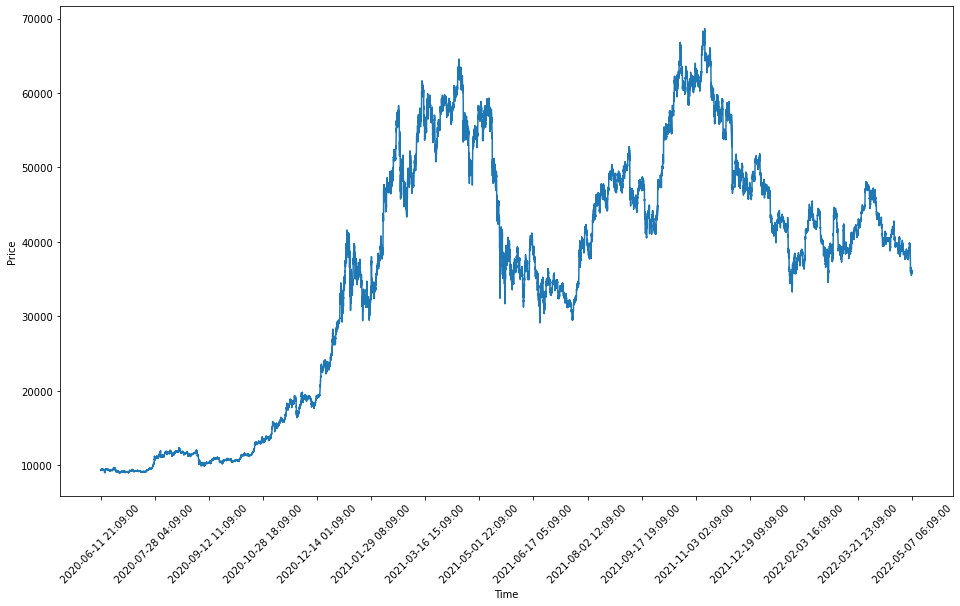

In [5]:
# Plot
plt.figure(figsize = (16,9))
plt.plot(np.arange(0,df.shape[0]),(df["Close"]+df["Open"])/2)
plt.xticks(np.arange(0,df.shape[0],len(df)//15), df["Time_UTC_Start"][::len(df)//15],rotation=45)
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

## Add more data

Bài này t tính giá trung bình trong mỗi phiên giao dịch rồi so sánh cái giá trung bình của 2 hàng liên tiếp chứ không dùng tới label như ban đầu nên sẽ khác (lưu ý nhá).

In [6]:
# Create columns
df["Avg_price"] = df["Quote_asset_volume"]/df["Volumn"]

df.dropna(inplace=True)
c1 = pd.DataFrame({
    "Diff1": df["Close"] - df["Close"].shift(1),
    "Zero": [0 for i in np.arange(len(df))]
})
c2 = pd.DataFrame({
    "Diff2": df["Close"] - df["Close"].shift(1),
    "Zero": [0 for i in np.arange(len(df))]
})
df["Up"] = c1.max(axis=1)
df["Down"] = c2.min(axis=1)

for i in [5,10,20,50]:
    df["SMA%i"%(i)] = df["Avg_price"].rolling(i, closed="left").mean() # closed="left" is used for avoiding leaked data
    df["SMAUp%i"%(i)] = df["Up"].rolling(i, closed="left").mean()
    df["SMADown%i"%(i)] = df["Down"].rolling(i, closed="left").mean()
    df.dropna(inplace=True)
    df["RS%i"%(i)] = df["SMAUp%i"%(i)] / (0.001 - df["SMADown%i"%(i)]) # 0.001 is used for avoiding zero division
    df["RSI%i"%(i)] = 100 - 100/(1 + df["RS%i"%(i)])
    
    df.dropna(inplace=True)

    df["Difference"] = df["Up"] + df["Down"]
    df["Difference_SMA%i"%(i)] = df["SMAUp%i"%(i)] + df["SMADown%i"%(i)]
    
    df.drop(columns=["SMAUp%i"%(i),"SMADown%i"%(i)])

# Drop columns
df.drop(columns=["Time_UTC_Start", "Timestamp End", "Number_of_trades", "Up", "Down"], inplace=True)

# Save the index column of difference, we'll predict this feature
diff_price_col_idx = df.columns.get_loc("Difference")

/tmp/ipykernel_10361/201098417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Avg_price"] = df["Quote_asset_volume"]/df["Volumn"]
/tmp/ipykernel_10361/201098417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/tmp/ipykernel_10361/201098417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

/tmp/ipykernel_10361/201098417.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SMA%i"%(i)] = df["Avg_price"].rolling(i, closed="left").mean() # closed="left" is used for avoiding leaked data
/tmp/ipykernel_10361/201098417.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SMAUp%i"%(i)] = df["Up"].rolling(i, closed="left").mean()
/tmp/ipykernel_10361/201098417.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [7]:
# Convert all dataframes to numpy
train_df = df.iloc[0:int(len(df)*0.8),:]
train_data = train_df.to_numpy()
num_rows_train, num_cols_train = train_data.shape
test_df = df.iloc[int(len(df)*0.8):]
test_data = test_df.to_numpy()
num_rows_test, num_cols_test = test_data.shape

In [8]:
steps = 20

# Make copies of test_data and train_data
test_data_cpy = test_data.copy()
train_data_cpy = train_data.copy()

# MinMaxScaler for training data, we take only {steps} row before to apply MinMaxScaler() in these rows
for i in range(steps, num_rows_train):
    scaler = MinMaxScaler(feature_range=(-1,1)).fit(train_data_cpy[i-steps:i])
    train_data[i] = scaler.transform(train_data_cpy[i].reshape(1, -1))
    del scaler
    
train_data = train_data[51:]

In [9]:
# MinMaxScaler for test data, we take only {steps} row before to apply MinMaxScaler() in these rows
for i in range(num_rows_test):
    if i > steps:
        scaler = MinMaxScaler(feature_range=(-1,1)).fit(test_data_cpy[i-steps:i])
        test_data[i] = scaler.transform(test_data_cpy[i].reshape(1, -1))
        del scaler
    else:
        scaler = MinMaxScaler(feature_range=(-1,1)).fit(np.array(test_data_cpy[:i].tolist() + train_data_cpy[-steps:].tolist()))
        test_data[i] = scaler.transform(test_data_cpy[i].reshape(1, -1))
        del scaler

In [10]:
def split_sequences(data, window_size):
    x = []
    y = []
    for i in range(0,len(data)-window_size):
        x.append(data[i:i+window_size,:]) # Take window_size rows data before
        y.append(data[i+window_size,diff_price_col_idx]) # To predict the current value of 'difference' column
    return np.array(x), np.array(y)

In [16]:
x_train, y_train = split_sequences(train_data, steps)
x_test, y_test = split_sequences(test_data, steps)

In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3' # For removing alert

print('Build model...')
model = Sequential()
model.add(GRU(128, input_shape=(steps,x_train.shape[2])))
model.add(Dense(64))
model.add(Dropout(rate=0.2))
model.add(GRU(16, input_shape=(steps,x_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

model.fit(x_train, y_train, batch_size=32, epochs=30)

Build model...


ValueError: Input 0 of layer "gru_3" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)

In [ ]:
'''
Function relabel(x) returns 1 if x > 0 (the current price is greater than the previous price) and 0 otherwise
'''
def relabel(x):
    if x > 0:
        return 1
    return 0

In [ ]:
# Calculate the predicted values
pred = model.predict(x_train)
del x_train # Free the memory

# Save to the csv files
pd.DataFrame(pred).to_csv("pred_train.csv")
pd.DataFrame(y_train).to_csv("y_train.csv")

del y_train # Free the memory

# Read the csv files
pred = pd.read_csv("pred_train.csv")
y_train = pd.read_csv("y_train.csv")

# Drop unnecessary columns
pred.drop(columns=["Unnamed: 0"], inplace=True)
y_train.drop(columns=["Unnamed: 0"], inplace=True)


'''
pred - y_train.shift(1) indicates the difference between the current predicted price and the previous price
np.vectorize(relabel) creates a mapping for relabel function
y_train - y_train.shift(1) indicates the difference between the current real price and the previous price
int(sum(diff == pred_label)/len(diff)) returns the accuracy of the model
'''

pred_label = np.vectorize(relabel)(pred)
train_df = train_df.iloc[-len(pred_label):,:]
diff_label = np.vectorize(relabel)(train_df["label"].to_numpy()).reshape(-1,1)
print("Accuracy in the training set: %f" % (float(sum(diff_label == pred_label)/len(diff_label))))

In [ ]:
# Calculate the predicted values
pred = model.predict(x_test)

# Save to the csv files
pd.DataFrame(pred).to_csv("pred.csv")
pd.DataFrame(y_test).to_csv("y_test.csv")

# Read the csv files
pred = pd.read_csv("pred.csv")
y_test = pd.read_csv("y_test.csv")

# Drop unnecessary columns
pred.drop(columns=["Unnamed: 0"], inplace=True)
y_test.drop(columns=["Unnamed: 0"], inplace=True)


'''
pred - y_test.shift(1) indicates the difference between the current predicted price and the previous price
np.vectorize(relabel) creates a mapping for relabel function
y_test - y_test.shift(1) indicates the difference between the current real price and the previous price
int(sum(diff == pred_label)/len(diff)) returns the accuracy of the model
'''
pred_label = np.vectorize(relabel)(pred)
test_df = test_df.iloc[-len(pred_label):,:]
print("Accuracy in the test set: %f" % (float(sum(df.iloc[-len(pred_label):,:]["label"].to_numpy().reshape((-1,1)) == pred_label)/len(pred_label))))